Fine tune TrOCR using Seq2SeqTrainer

## Set-up environment

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install datasets

In [ ]:
!pip install --upgrade torch

In [ ]:
!pip install jiwer

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import TrOCRProcessor
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

## Prepare data

In [15]:
df = pd.read_csv('/content/drive/MyDrive/assignments/IS 557 Final Project-selected/gt.csv', sep = ",", usecols = ["0", "1", "2"])
df.rename(columns={"0": "file_name", "1": "year", "2": "text"}, inplace=True)
print(df.head())

     file_name  year                                               text
0  002_080_001  2014   36 6. The evidence of the engagement, consign...
1  002_112_001  2014   [13][Me .... issuing Clerk] For the purpose o...
2  002_121_001  2014   31 [16] [Local Annuity Note Office in ....] T...
3  002_541_001  2014   Ch. III. Grounds of Expectation with regard t...
4  002_579_001  2014   (a)The distinction is material: for as fixed ...


In [ ]:
# import os

# existing_file_names = os.listdir("/content/drive/MyDrive/assignments/IS 557 Final Project-selected/historical-ocr-docs")
# indices_to_drop = []
# df_filtered = df.copy()
# for index, row in df.iterrows():
#     file_name = row["file_name"] + ".jpg"
#     if file_name not in existing_file_names:
#         indices_to_drop.append(index)

# df_filtered = df_filtered.drop(indices_to_drop)
# df_filtered


In [79]:
train_df, test_df = train_test_split(df, test_size=0.2)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
print(train_df.head())
print(test_df.head())

  file_name  year                                               text
0    013715  2017   in Folge der mit dem Minister gehabten Un-\nt...
1    018330  2017   Für das technische Gutachten ist die v. Ihnen...
2    013189  2017   \n        Glarus\n        31. Oct. 1840.\nMei...
3    018391  2017   Hochgeachteter Herr Präsident!\nIndem ich Ihn...
4    012194  2017   ich in ihm vor mir habe. Ich & der ganze Gott...
   file_name  year                                               text
0     019149  2017   Seiner hochwohlgeboren\nHerrn Präsidenten Dr ...
1  Seite0308  2016   154 154 ledigt Stel. des Bene¬ ficÿ im Spitta...
2     014464  2017   \n        Stuttgart\n        24 Mai 1864.\nLi...
3     018710  2017   war – sofort dem Herrn Fornerod mitgetheilt –...
4     013616  2017   Idealen so vieler, vieler Schweizer gehört un...


In [80]:
# Slice the first 100 samples from the training DataFrame
# To make the traning faster, just use the first 100samples
train_df = train_df[:100]
eval_df = test_df[:10]

In [81]:
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      # get file name + text
      file_name = self.df['file_name'][idx]
      text = str(self.df['text'][idx])  # convert text to string
      # prepare image (i.e. resize + normalize)
      image = Image.open(self.root_dir + file_name + ".jpg").convert("RGB")
      pixel_values = self.processor(image, return_tensors="pt").pixel_values
      # add labels (input_ids) by encoding the text
      labels = self.processor.tokenizer(text,
                                        padding="max_length",
                                        truncation=True,
                                        # ensure that all labels are the same length by truncating or padding them to a fixed length.
                                        max_length=self.max_target_length).input_ids
      # important: make sure that PAD tokens are ignored by the loss function
      labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

      encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
      return encoding

In [82]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='/content/drive/MyDrive/IS 557/historical-ocr-docs/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/content/drive/MyDrive/IS 557/historical-ocr-docs/',
                           df=test_df,
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [83]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 100
Number of validation examples: 2250


In [63]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


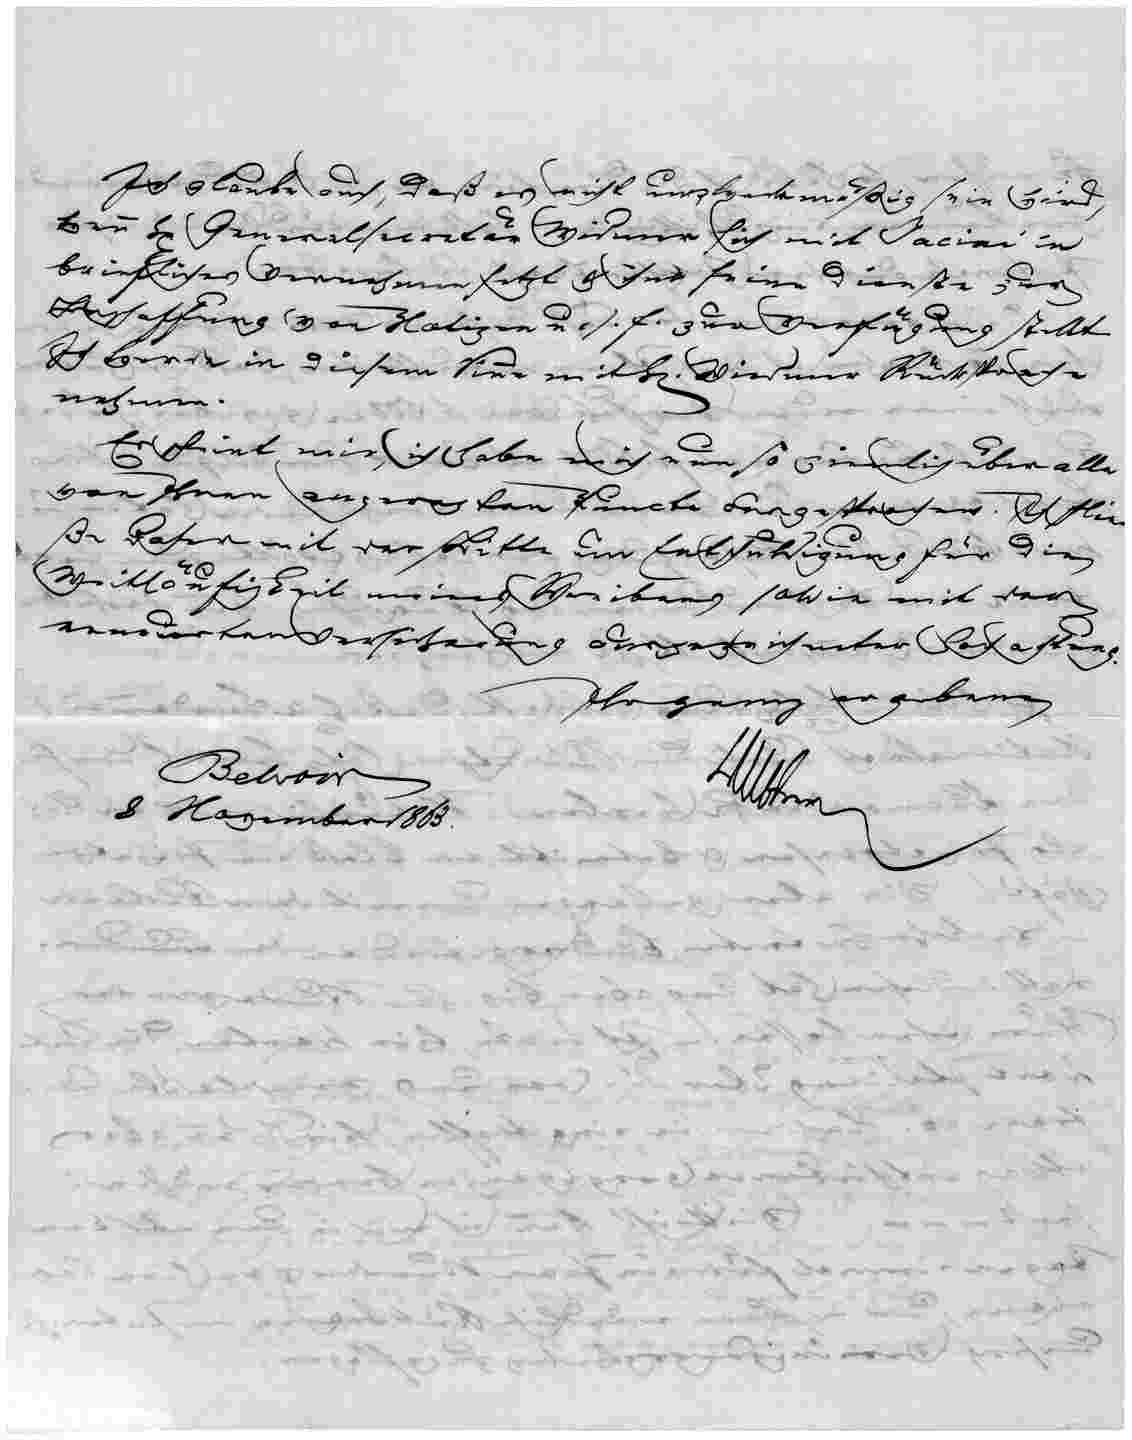

In [55]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]+ ".jpg").convert("RGB")
image

In [56]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

 Ich glaube auch, daß es nicht unzweckmäßig sein wird,
wenn Hr Generalsecretär Widmer sich mit Jacini in
briefliches Vernehmen setzt & ihm seine Dienste zur
Beschaffung von Notizen u. s. f. zur Verfügung stellt.
Ich werde in diesem Sinne mit Hrn. Wiedmer Rücksprache
nehmen.
Es scheint mir, ich


In [23]:
train_df.loc[0]['text']

' Ich glaube auch, daß es nicht unzweckmäßig sein wird,\nwenn Hr Generalsecretär Widmer sich mit Jacini in\nbriefliches Vernehmen setzt & ihm seine Dienste zur\nBeschaffung von Notizen u. s. f. zur Verfügung stellt.\nIch werde in diesem Sinne mit Hrn. Wiedmer Rücksprache\nnehmen.\nEs scheint mir, ich habe mich nun so ziemlich über alle\nvon Ihnen angeregten Puncte ausgesprochen. Ich schlie-\nße daher mit der Bitte um Entschuldigung für die\nWeitläufigkeit meines Schreibens sowie mit der\nerneuerten Versicherung ausgezeichneter Hochachtung.\nIhr ganz ergebene\nDr A Escher\n\n        Belvoir\n      \n\n        8 November 1863.'

## Train a model

In [24]:
from huggingface_hub import login
from transformers import VisionEncoderDecoderModel
from datasets import load_metric

In [25]:
login(
token="fjdjfjseoijdoiasmklfnjkscnjkdse", # ADD YOUR TOKEN HERE
add_to_git_credential=True
)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [67]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [65]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="IS557_TrOCR",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

In [31]:
cer_metric = load_metric("cer")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [32]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [49]:
from transformers import DataCollatorWithPadding

class CustomDataCollator(DataCollatorWithPadding):
    def __init__(self, processor):
        super().__init__(processor.tokenizer)

    def __call__(self, features):
        pixel_values = [feature['pixel_values'] for feature in features]
        labels = [feature['labels'] for feature in features]

        # We need to pad the images manually as the default collator does not support it
        max_size = max([px.shape for px in pixel_values], key=lambda x: x[1]*x[2])
        pixel_values = [torch.nn.functional.pad(px, (0, max_size[2]-px.shape[2], 0, max_size[1]-px.shape[1])) for px in pixel_values]

        batch = {'pixel_values': torch.stack(pixel_values), 'labels': torch.stack(labels)}
        return batch

data_collator = CustomDataCollator(processor)

In [84]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)


trainer.train()
trainer.save_model()

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

In [86]:
# Push the model to your Hugging Face account
trainer.push_to_hub()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

events.out.tfevents.1712025747.81ed719bbfbd.6349.11:   0%|          | 0.00/8.58k [00:00<?, ?B/s]

events.out.tfevents.1712025792.81ed719bbfbd.6349.12:   0%|          | 0.00/9.83k [00:00<?, ?B/s]

events.out.tfevents.1712026049.81ed719bbfbd.6349.13:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/ShuyiGuo/IS557_TrOCR/commit/e3a421a13d568649227457252a0134cd010f60ad', commit_message='End of training', commit_description='', oid='e3a421a13d568649227457252a0134cd010f60ad', pr_url=None, pr_revision=None, pr_num=None)